In [3]:
import numpy as np 
import pandas as pd 

My Functions:

In [4]:
def datetounix(df):
    unixtime = []
    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))
    df['DateTime'] = unixtime
    return(df)

Importing all the Libraries at one go

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from sklearn.ensemble import ExtraTreesClassifier
import operator
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

**Data Cleaning**

First task at hand is data cleaning. Loading Data from dataset and cleaning it up.

In [6]:
df_train = pd.read_csv('Train.csv', encoding='ISO-8859-1', engine='c')
df_test = pd.read_csv('Test.csv', encoding='ISO-8859-1', engine='c')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  11808 non-null  object
 1   Junction  11808 non-null  int64 
 2   ID        11808 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 276.9+ KB


In [9]:
df_train['DateTime'] = pd.to_datetime(df_train['DateTime'], format='%d/%m/%Y %H:%M', dayfirst=True)
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'], format='%d/%m/%Y %H:%M', dayfirst=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  11808 non-null  datetime64[ns]
 1   Junction  11808 non-null  int64         
 2   ID        11808 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 276.9 KB


In [11]:
df_train['Weekday'] = [datetime.weekday(date) for date in df_train.DateTime]
df_train['Year'] = [date.year for date in df_train.DateTime]
df_train['Month'] = [date.month for date in df_train.DateTime]
df_train['Day'] = [date.day for date in df_train.DateTime]
df_train['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df_train.DateTime]
df_train['Week'] = [date.week for date in df_train.DateTime]
df_train['Quarter'] = [date.quarter for date in df_train.DateTime]

Analysis: To assess next steps

Feature ranking:
feature 0 : DateTime (0.373164)
feature 7 : Time (0.356976)
feature 6 : Day (0.065454)
feature 3 : Weekday (0.060834)
feature 2 : ID (0.051714)
feature 1 : Junction (0.050360)
feature 8 : Week (0.030058)
feature 5 : Month (0.007389)
feature 9 : Quarter (0.002145)
feature 4 : Year (0.001906)


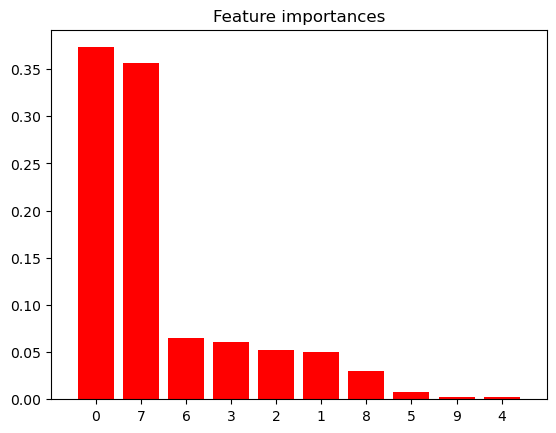

In [12]:
tree_clf = ExtraTreesClassifier()
df_train_features = df_train.drop(['Vehicles'], axis=1)
df_train_features = datetounix(df_train_features)
X = df_train_features.values
y = df_train['Vehicles'].values
tree_clf.fit(X, y)
importances = tree_clf.feature_importances_
feature_names = df_train_features.columns.tolist()

feature_imp_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)

indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X.shape[1]):
    print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))
plt.figure(0)
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

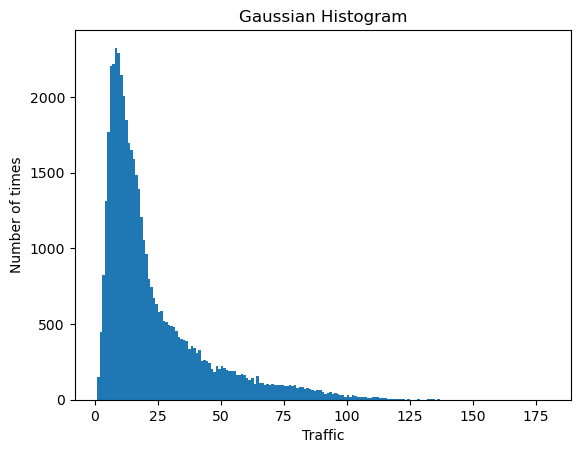

In [13]:
data = df_train.Vehicles
binwidth = 1
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth), log=False)
plt.title("Gaussian Histogram")
plt.xlabel("Traffic")
plt.ylabel("Number of times")
plt.show()

Data Preparation:

In [14]:
df_test_features = datetounix(df_test.drop(['Year', 'Quarter', 'Month', 'ID'], axis=1))
X_test = df_test_features.values
df_train_features = df_train.drop(['Vehicles','Year', 'Quarter', 'Month', 'ID'], axis=1)
df_train_features = datetounix(df_train_features)
X = df_train_features.values
y = df_train['Vehicles'].values

Using Decision Tree to Learn

In [15]:
df_solution = pd.DataFrame()
df_solution['ID'] = df_test.ID
start_time = time.time()
clf = DecisionTreeClassifier(criterion='gini', random_state = 13)
clf.fit(X, y)
predictions = clf.predict(X_test)
print("The time taken to execute is %s seconds" % (time.time() - start_time))
df_solution['Vehicles'] = predictions
df_solution

The time taken to execute is 1.8502540588378906 seconds


,ID,Vehicles
0,20170701001,70
1,20170701011,62
2,20170701021,52
3,20170701031,39
4,20170701041,40
...,...,...
11803,20171031194,30
11804,20171031204,30
11805,20171031214,16
11806,20171031224,22


In [16]:
df_pred = pd.DataFrame(df_solution)

In [17]:
df_pred['new_index'] = [n for n in range(48120, 59928)]

In [ ]:
df_pred.set_index('new_index', inplace = True)
df = pd.merge(df_test.drop(['DateTime', 'Weekday', 'Year', 'Month', 'Day', 'Time', 'Week', 'Quarter'], axis = 1), df_pred, 
              how='inner', on = 'ID')
df.set_index(df_pred.index, inplace = True)
frames = [df_train.drop(['DateTime', 'Weekday', 'Year', 'Month', 'Day', 'Time', 'Week', 'Quarter'], axis = 1), df]
df = pd.concat(frames)
df

In [ ]:
df[df['Junction'] == 1]['Vehicles'].plot(legend=True, label='Junction1')

<Axes: >

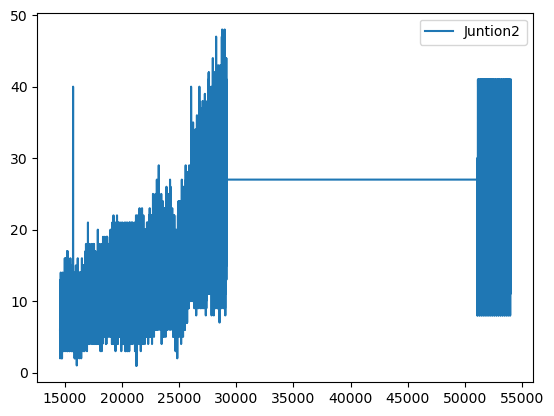

In [26]:
df[df['Junction'] == 2]['Vehicles'].plot(legend=True, label='Juntion2')

<Axes: >

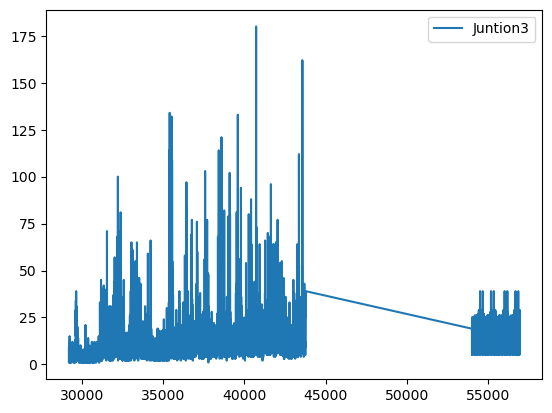

In [27]:
df[df['Junction'] == 3]['Vehicles'].plot(legend=True, label='Juntion3')

<Axes: >

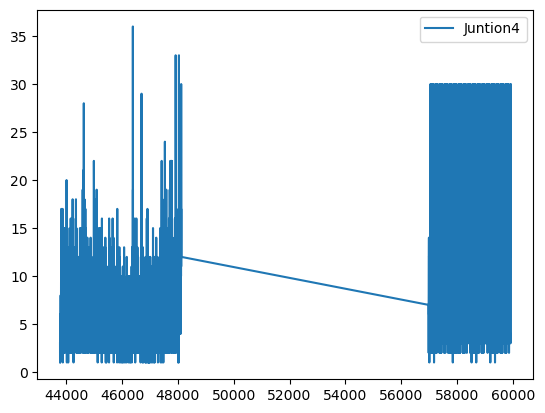

In [28]:
df[df['Junction'] == 4]['Vehicles'].plot(legend=True, label='Juntion4')

<Axes: xlabel='new_index'>

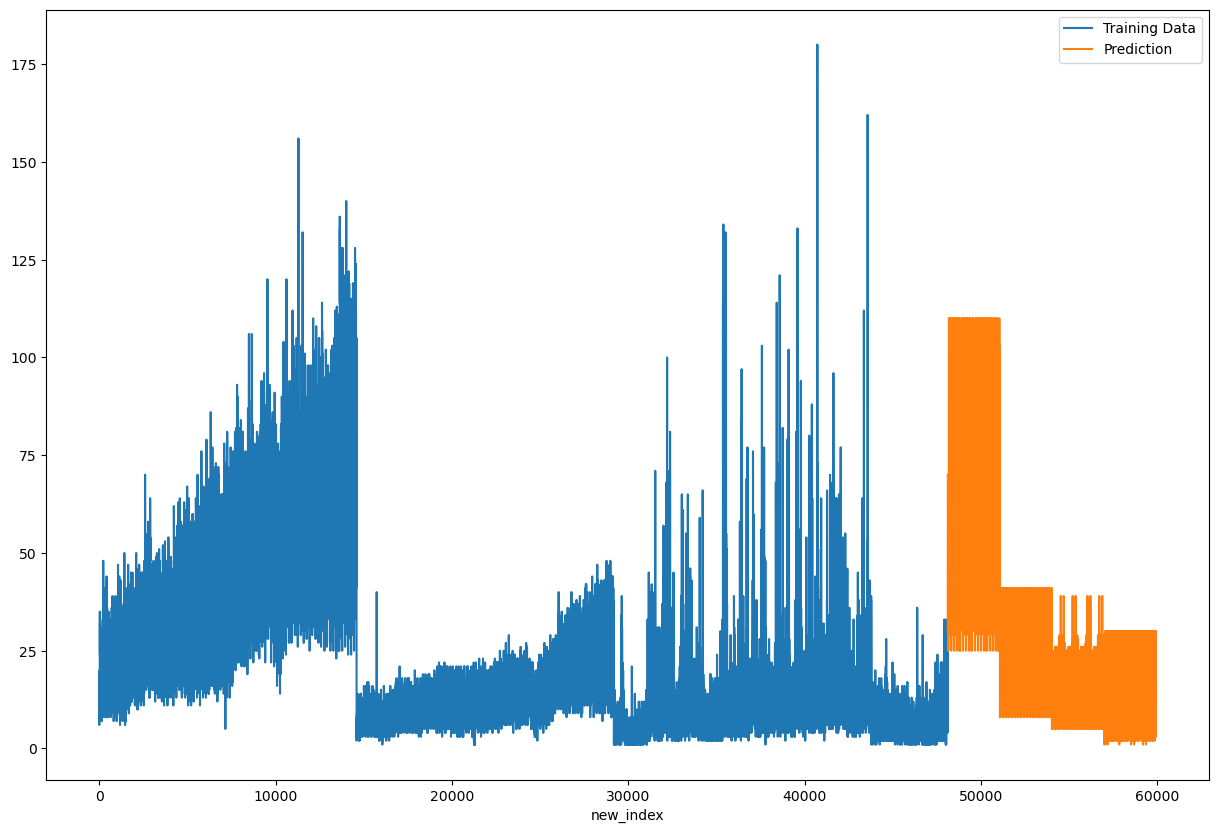

In [29]:
df_train['Vehicles'].plot(legend=True, label='Training Data', figsize=(15,10))
df_pred['Vehicles'].plot(legend=True, label='Prediction')

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
data = load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)


DecisionTreeClassifier()

In [5]:
pred = dtree.predict(X_test)

In [6]:
from sklearn import metrics

In [7]:
metrics.mean_absolute_error(y_test, pred)

0.0

In [8]:
metrics.mean_squared_error(y_test, pred)

0.0

In [12]:
from sklearn import metrics
import numpy as np
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 0.0
